## Resume Classification
### Business objective:
* **The document classification solution should significantly reduce the manual human effort in the HRM. It should achieve a higher level of accuracy and automation with minimal human intervention**

## 1. Import Library

In [8]:
import glob
from pathlib import Path
import spacy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from PyPDF2 import PdfReader
import subprocess
from docx import Document


from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.svm import SVC
import lightgbm as lgb
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import f1_score, classification_report, precision_score, recall_score, confusion_matrix, accuracy_score

import warnings
warnings.filterwarnings('ignore')

## 2. About Dataset

In [9]:
all_files = glob.glob("Resumes_Docx/*/*")
all_files = [f.replace("\\", "/") for f in all_files]

In [10]:
df = pd.DataFrame({"path": all_files})
df["folder"] = df["path"].apply(lambda x: Path(x).parent.name)
df["ext"]    = df["path"].apply(lambda x: Path(x).suffix.replace(".", "").lower())
df

,path,folder,ext
0,Resumes_Docx/Peoplesoft/Peoplesoft Admin_G Ana...,Peoplesoft,docx
1,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx
2,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc
3,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc
4,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx
...,...,...,...
75,Resumes_Docx/workday/Sri Krishna S_Hexaware.doc,workday,doc
76,Resumes_Docx/workday/Srikanth-Hexaware.docx,workday,docx
77,Resumes_Docx/workday/SSKumar_Hexaware.docx,workday,docx
78,Resumes_Docx/workday/Venkateswarlu B_Hexaware.doc,workday,doc


### 2.1 Type of Table Format

In [11]:
folder_ext_counts = df.groupby(["folder", "ext"]).size().reset_index(name="count").sort_values(by=["folder", "ext"])
folder_ext_counts.index = folder_ext_counts.index + 1
folder_ext_counts

,folder,ext,count
1,Peoplesoft,docx,1
2,Peoplesoft Resume,doc,10
3,Peoplesoft Resume,docx,10
4,React Developer,doc,3
5,React Developer,docx,20
6,React Developer,pdf,1
7,SQL Developer,doc,3
8,SQL Developer,docx,11
9,workday,doc,10
10,workday,docx,11


In [12]:
pivot_df = df.pivot_table(index="folder", columns="ext", aggfunc="size", fill_value=0)
pivot_df = pivot_df[pivot_df.sum(axis=1) != 0]
pivot_df

ext,doc,docx,pdf
folder,,,
Peoplesoft,0,1,0
Peoplesoft Resume,10,10,0
React Developer,3,20,1
SQL Developer,3,11,0
workday,10,11,0


### 2.2 Type of Folder vs File Count

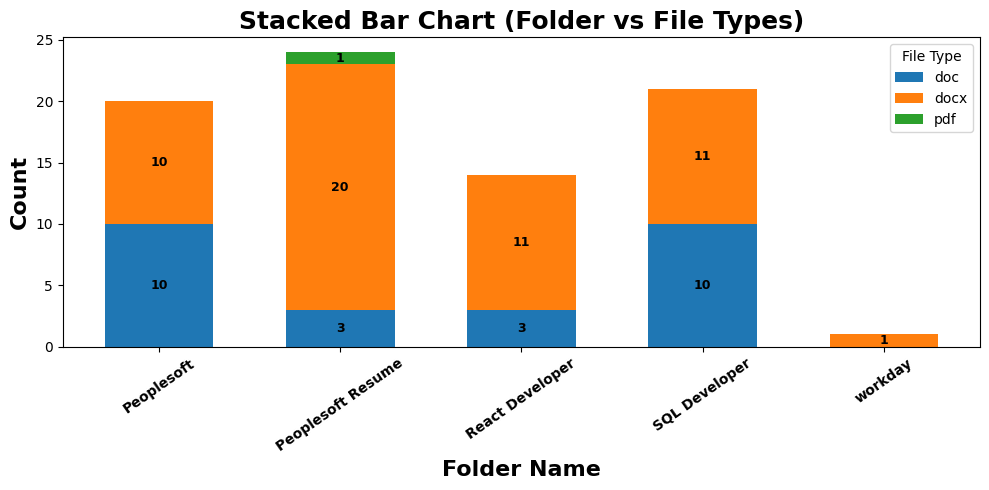

In [19]:
x = np.arange(len(pivot_df.index))
width = 0.6
fig, ax = plt.subplots(figsize=(10, 5))
bottom = np.zeros(len(pivot_df.index))
for i, ext in enumerate(pivot_df.columns):
    values = pivot_df[ext].values
    mask = values > 0
    if not np.any(mask):
        continue
    p = ax.bar(pivot_df.index[mask], values[mask], width, label=ext, bottom=bottom[mask],)
    for rect, v in zip(p, values[mask]):
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height() / 2, f"{v}",
                ha='center', va='center',fontsize=9, fontweight='bold')
    bottom[mask] += values[mask]
ax.set_xlabel("Folder Name", size=16, fontweight='bold')
ax.set_ylabel("Count", size=16, fontweight='bold')
ax.set_title("Stacked Bar Chart (Folder vs File Types)", fontsize=18, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(pivot_df.index, rotation=35,fontweight='bold')
ax.legend(title="File Type")
plt.tight_layout()
plt.show()

In [20]:
folder_ext_counts = df.groupby("ext").size().reset_index(name="count")
folder_ext_counts.index = folder_ext_counts.index + 1
folder_ext_counts

,ext,count
1,doc,26
2,docx,53
3,pdf,1


In [21]:
total_count = folder_ext_counts["count"].sum()

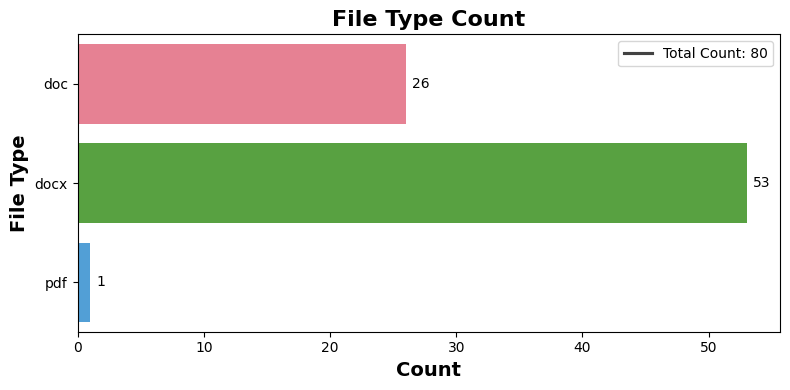

In [22]:
plt.figure(figsize=(8, 4))
palette = sns.color_palette("husl", len(folder_ext_counts))
ax = sns.barplot(data=folder_ext_counts,x="count",y="ext",orient="h",palette=palette)
for index, value in enumerate(folder_ext_counts["count"]):
    ax.text(value+0.5,index, str(value), va='center', fontsize=10,)
plt.xlabel("Count", fontsize=14, fontweight="bold")
plt.ylabel("File Type", fontsize=14, fontweight="bold")
plt.title("File Type Count", fontsize=16, fontweight="bold")
ax.legend([f"Total Count: {total_count}"],loc="upper right",frameon=True)
plt.tight_layout()
plt.show()


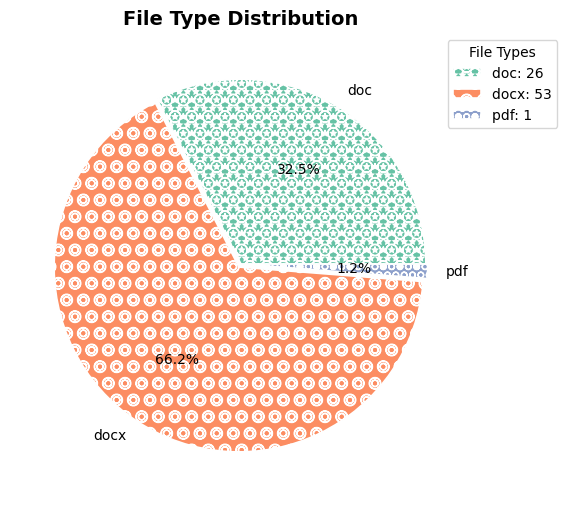

In [23]:
plt.figure(figsize=(6, 6))
colors = sns.color_palette('Set2')
explode = (0.00, 0.02, 0.01)
wedges, texts, autotexts =plt.pie(folder_ext_counts["count"], labels=folder_ext_counts["ext"],hatch=['**O', 'oO', 'O.O', '.||.'], 
    autopct="%1.1f%%", colors=colors, explode= explode,wedgeprops=dict(edgecolor="white", linewidth=1.2))
plt.legend(
    wedges,
    [f"{ext}: {cnt}" for ext, cnt in zip(folder_ext_counts["ext"], folder_ext_counts["count"])],
    title="File Types",
    loc="upper right",
    bbox_to_anchor=(1.2, 1)
)

plt.title("File Type Distribution", fontsize=14, fontweight="bold")
plt.show()

## 3. Extract Resumes by Profile Category

In [24]:
resume_data = df.groupby("folder").size().reset_index(name="count")
resume_data = resume_data.rename(columns={"folder": "Profile"})
resume_data.index = resume_data.index + 1
resume_data

,Profile,count
1,Peoplesoft,1
2,Peoplesoft Resume,20
3,React Developer,24
4,SQL Developer,14
5,workday,21


### 3.1 Percentage of Profiles Category¶

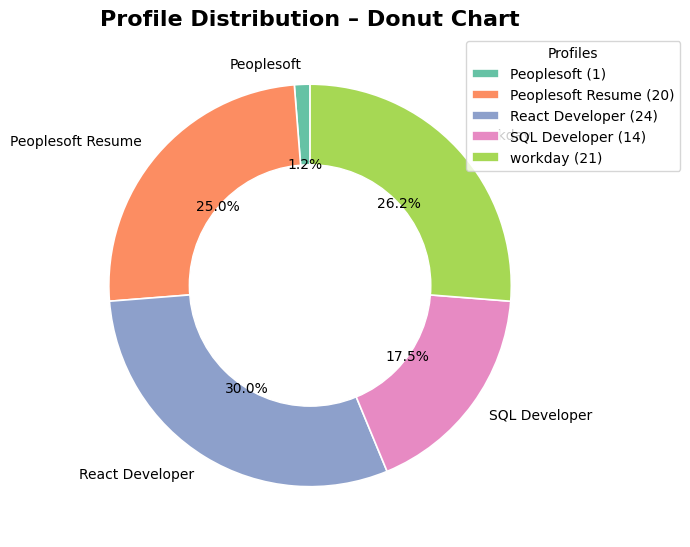

In [25]:
colors = sns.color_palette("Set2", len(resume_data))
plt.figure(figsize=(7, 7))
wedges, texts, autotexts = plt.pie(resume_data["count"],labels=resume_data["Profile"],autopct="%1.1f%%",startangle=90,
    colors=colors,wedgeprops={"edgecolor": "white", "linewidth": 1.2})
centre_circle = plt.Circle((0, 0), 0.60, color='white')
plt.legend(wedges, [f"{p} ({c})" for p, c in zip(resume_data["Profile"], resume_data["count"])],
    title="Profiles",loc="upper right",bbox_to_anchor=(1.25, 1))
plt.gca().add_artist(centre_circle)
plt.title("Profile Distribution – Donut Chart", fontsize=16, fontweight="bold")
plt.tight_layout()
plt.show()

#### 3.2 Number of Total Resumes

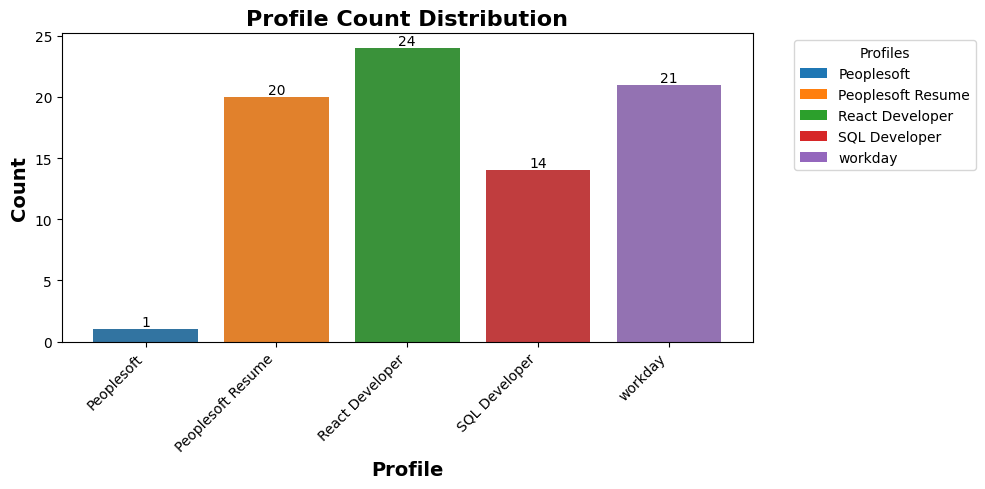

In [26]:
plt.figure(figsize=(10,5))
palette = sns.color_palette("tab10", len(resume_data))
ax = sns.barplot(data=resume_data, x="Profile", y="count", palette=palette)
for i, row in resume_data.iterrows():
    ax.text(i-1, row['count'], row['count'], ha='center', va='bottom')
for i, profile in enumerate(resume_data["Profile"]):
    plt.bar(0, 0, color=palette[i], label=profile)
plt.legend(title="Profiles", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.title("Profile Count Distribution",fontsize=16, fontweight="bold")
plt.xlabel("Profile", fontsize=14, fontweight="bold")
plt.ylabel("Count", fontsize=14, fontweight="bold")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## 4. Reading a Resume File

In [27]:
def read_file(file_path):
    try:
        if file_path.endswith(".docx"):
            doc = Document(file_path)
            text = "\n".join([p.text for p in doc.paragraphs])
            return text
        if file_path.endswith(".pdf"):
            reader = PdfReader(file_path)
            return "\n".join(page.extract_text() or "" for page in reader.pages)
        if file_path.endswith(".doc"):
            result = subprocess.run(["antiword", file_path], stdout=subprocess.PIPE, stderr=subprocess.PIPE)
            return result.stdout.decode("utf-8", errors="ignore")

    except:
        pass


In [28]:
df["text"] = df["path"].apply(read_file)
df

,path,folder,ext,text
0,Resumes_Docx/Peoplesoft/Peoplesoft Admin_G Ana...,Peoplesoft,docx,None
1,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Anubhav Kumar Singh\t\t\n\n To work in a gl...
2,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc,None
3,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,doc,None
4,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Murali\n\nExperience Summary \n\nI have 6 year...
...,...,...,...,...
75,Resumes_Docx/workday/Sri Krishna S_Hexaware.doc,workday,doc,None
76,Resumes_Docx/workday/Srikanth-Hexaware.docx,workday,docx,Seeking suitable positions in Workday HCM as ...
77,Resumes_Docx/workday/SSKumar_Hexaware.docx,workday,docx,\nWORKDAY | HCM | FCM\nName \t\t: Kumar S.S\nR...
78,Resumes_Docx/workday/Venkateswarlu B_Hexaware.doc,workday,doc,None


In [29]:
resume_data = df[df["text"].notna() & (df["text"] != "")].reset_index(drop=True)
resume_data.head()

,path,folder,ext,text
0,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Anubhav Kumar Singh\t\t\n\n To work in a gl...
1,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Murali\n\nExperience Summary \n\nI have 6 year...
2,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,\n\n\n\n\n\n\n\n\n\n\n\n\n\nPROFILE SUMMARY\n\...
3,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,PeopleSoft Admin\nVARKALA VIKAS\n\nCareer Obj...
4,Resumes_Docx/Peoplesoft Resume/PeopleSoft DBA_...,Peoplesoft Resume,docx,PeopleSoft Administration\n \nVivekanand Sayan...


In [30]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
resume_data['Word_Count'] = resume_data['text'].apply(lambda x: len(str(x).split(" ")))
resume_data['Char_Count'] = resume_data['text'].str.len() 
resume_data['Stopwords'] = resume_data['text'].apply(lambda x: len([x for x in x.split() if x in stop]))
resume_data['Numerics'] = resume_data['text'].apply(lambda x: len([x for x in x.split() if x.isdigit()]))
resume_data[['text','Word_Count','Char_Count','Stopwords','Numerics']].head()

,text,Word_Count,Char_Count,Stopwords,Numerics
0,Anubhav Kumar Singh\t\t\n\n To work in a gl...,978,7256,187,3
1,Murali\n\nExperience Summary \n\nI have 6 year...,494,3981,111,1
2,\n\n\n\n\n\n\n\n\n\n\n\n\n\nPROFILE SUMMARY\n\...,451,3646,86,15
3,PeopleSoft Admin\nVARKALA VIKAS\n\nCareer Obj...,881,7265,224,3
4,PeopleSoft Administration\n \nVivekanand Sayan...,2508,15339,519,16


In [31]:
import re
from nltk.tokenize import RegexpTokenizer

In [32]:
def preprocess(sentence):
    sentence = str(sentence)
    sentence = sentence.lower()
    sentence = sentence.replace('{html}',"") 
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, '', sentence)
    rem_url = re.sub(r'http\S+', '',cleantext)
    rem_num = re.sub('[0-9]+', '', rem_url)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(rem_num)  
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords.words('english')]

    return " ".join(filtered_words)

In [33]:
resume_data['Resume_Details'] = resume_data.text.apply(lambda x: preprocess(x))
resume_data['Resume_Details'].head()

0    anubhav kumar singh work globally competitive ...
1    murali experience summary years experience wor...
2    profile summary overall years experience peopl...
3    peoplesoft admin varkala vikas career objectiv...
4    peoplesoft administration vivekanand sayana ca...
Name: Resume_Details, dtype: object

In [34]:
resume_data.Resume_Details[0]

'anubhav kumar singh work globally competitive environment challenging assignments shall yield twin benefits job satisfaction steady paced professional growth professional experience current hcl current role system admin offshore skills shell scripting linux peoplesoft administration github managing peoplesoft hcm peoplesoft fscm production environments along support environments installed linux windows involved day day activities project migration database refresh system admin changes tax updates etc troubleshooting various servers like application servers web servers process scheduler servers applying tuxedo weblogic middleware cpu patches various applications working shell scripting used integration method exchange files external systems installation troubleshooting tier setup per requirement reviewing vulnerabilities reported security teams renewal ssl weblogic vulnerability remediation whenever vulnerability report rmis team worked pum peoplesoft update manager installation dpk wo

In [35]:
import nltk
import string

In [36]:
oneSetOfStopWords = set(stopwords.words('english')+['``',"''"])
totalWords =[]
Sentences = resume_data['Resume_Details'].values
cleanedSentences = ""
for records in Sentences:
    cleanedText = preprocess(records)
    cleanedSentences += cleanedText
    requiredWords = nltk.word_tokenize(cleanedText)
    for word in requiredWords:
        if word not in oneSetOfStopWords and word not in string.punctuation:
            totalWords.append(word)
    
wordfreqdist = nltk.FreqDist(totalWords)
mostcommon = wordfreqdist.most_common(50)
print(mostcommon)

[('experience', 313), ('using', 247), ('workday', 194), ('application', 187), ('sql', 178), ('project', 177), ('server', 168), ('data', 167), ('reports', 164), ('peoplesoft', 156), ('business', 156), ('knowledge', 130), ('web', 125), ('process', 120), ('react', 119), ('good', 103), ('skills', 102), ('involved', 99), ('client', 98), ('system', 97), ('like', 96), ('working', 96), ('various', 95), ('creating', 94), ('worked', 92), ('support', 91), ('development', 91), ('integrations', 90), ('database', 86), ('tools', 84), ('technical', 84), ('servers', 83), ('developer', 83), ('integration', 81), ('design', 79), ('hcm', 78), ('created', 76), ('used', 74), ('report', 74), ('team', 71), ('people', 71), ('services', 71), ('html', 71), ('work', 70), ('testing', 69), ('responsibilities', 68), ('new', 66), ('custom', 66), ('role', 65), ('user', 64)]


In [37]:
nlp = spacy.load('en_core_web_lg')
one_block = cleanedSentences[1300:5200]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block, style= 'ent', jupyter= True)

In [38]:
for token in doc_block[:30]:
    print(token,token.pos_)  

upgrade VERB
project NOUN
migration NOUN
applications NOUN
ntt PROPN
cloud PROPN
premises NOUN
aws PROPN
cloud PROPN
worked VERB
shell NOUN
scripting NOUN
various ADJ
application NOUN
requirement NOUN
working VERB
ansible PROPN
jenkins PROPN
automated VERB
start PROPN
stop VERB
various ADJ
activities NOUN
application VERB
basic ADJ
knowledge NOUN
docker NOUN
applying VERB
ssl PROPN
certificates NOUN


In [39]:
one_block = cleanedSentences
doc_block = nlp(one_block)
nouns_verbs = [token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[:250])

['work', 'environment', 'challenging', 'assignments', 'yield', 'benefits', 'job', 'satisfaction', 'paced', 'growth', 'experience', 'role', 'system', 'admin', 'skills', 'shell', 'scripting', 'managing', 'fscm', 'production', 'environments', 'support', 'environments', 'installed', 'windows', 'involved', 'day', 'day', 'activities', 'project', 'migration', 'database', 'refresh', 'system', 'admin', 'changes', 'tax', 'updates', 'troubleshooting', 'servers', 'application', 'servers', 'web', 'servers', 'process', 'scheduler', 'servers', 'applying', 'tuxedo', 'weblogic', 'middleware', 'cpu', 'patches', 'applications', 'working', 'shell', 'scripting', 'used', 'integration', 'method', 'exchange', 'files', 'systems', 'installation', 'troubleshooting', 'tier', 'setup', 'requirement', 'reviewing', 'vulnerabilities', 'reported', 'security', 'teams', 'renewal', 'weblogic', 'vulnerability', 'remediation', 'vulnerability', 'report', 'team', 'worked', 'update', 'manager', 'installation', 'working', 'know

In [40]:
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)
words_freq = [(word,sum_words[0,idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
wd_df = pd.DataFrame(words_freq)
wd_df.columns = ['Words','Count']
wd_df[0:15]

,Words,Count
0,experience,285
1,using,246
2,application,186
3,project,167
4,reports,164
5,data,159
6,business,149
7,workday,147
8,web,125
9,process,119


### 5.1 N-grams
* **N-grams analyses are often used to see which words often show up together.**

In [41]:
TextBlob(resume_data['Resume_Details'][1]).ngrams(3)[:20]

[WordList(['murali', 'experience', 'summary']),
 WordList(['experience', 'summary', 'years']),
 WordList(['summary', 'years', 'experience']),
 WordList(['years', 'experience', 'working']),
 WordList(['experience', 'working', 'peoplesoft']),
 WordList(['working', 'peoplesoft', 'administration']),
 WordList(['peoplesoft', 'administration', 'performing']),
 WordList(['administration', 'performing', 'various']),
 WordList(['performing', 'various', 'infrastructure']),
 WordList(['various', 'infrastructure', 'related']),
 WordList(['infrastructure', 'related', 'activities']),
 WordList(['related', 'activities', 'peoplesoft']),
 WordList(['activities', 'peoplesoft', 'environments']),
 WordList(['peoplesoft', 'environments', 'installed']),
 WordList(['environments', 'installed', 'configured']),
 WordList(['installed', 'configured', 'peoplesoft']),
 WordList(['configured', 'peoplesoft', 'web']),
 WordList(['peoplesoft', 'web', 'server']),
 WordList(['web', 'server', 'application']),
 WordList([

### 5.2 Top 20 most used words in Resumes
* **Using CountVectorizer**

In [42]:
countvec = CountVectorizer(stop_words=stopwords.words('english'), ngram_range=(1,2))
ngrams = countvec.fit_transform(resume_data['Resume_Details']) 
count_values = ngrams.toarray().sum(axis=0) 

vocab = countvec.vocabulary_ 
df_ngram = pd.DataFrame(sorted([(count_values[i],k) for k, i in vocab.items()],
                               reverse=True)).rename(columns={0: 'Frequency', 1:'Unigram_Bigram'})

In [43]:
df_ngram.head(20)

,Frequency,Unigram_Bigram
0,313,experience
1,247,using
2,194,workday
3,187,application
4,178,sql
5,177,project
6,168,server
7,167,data
8,164,reports
9,156,peoplesoft


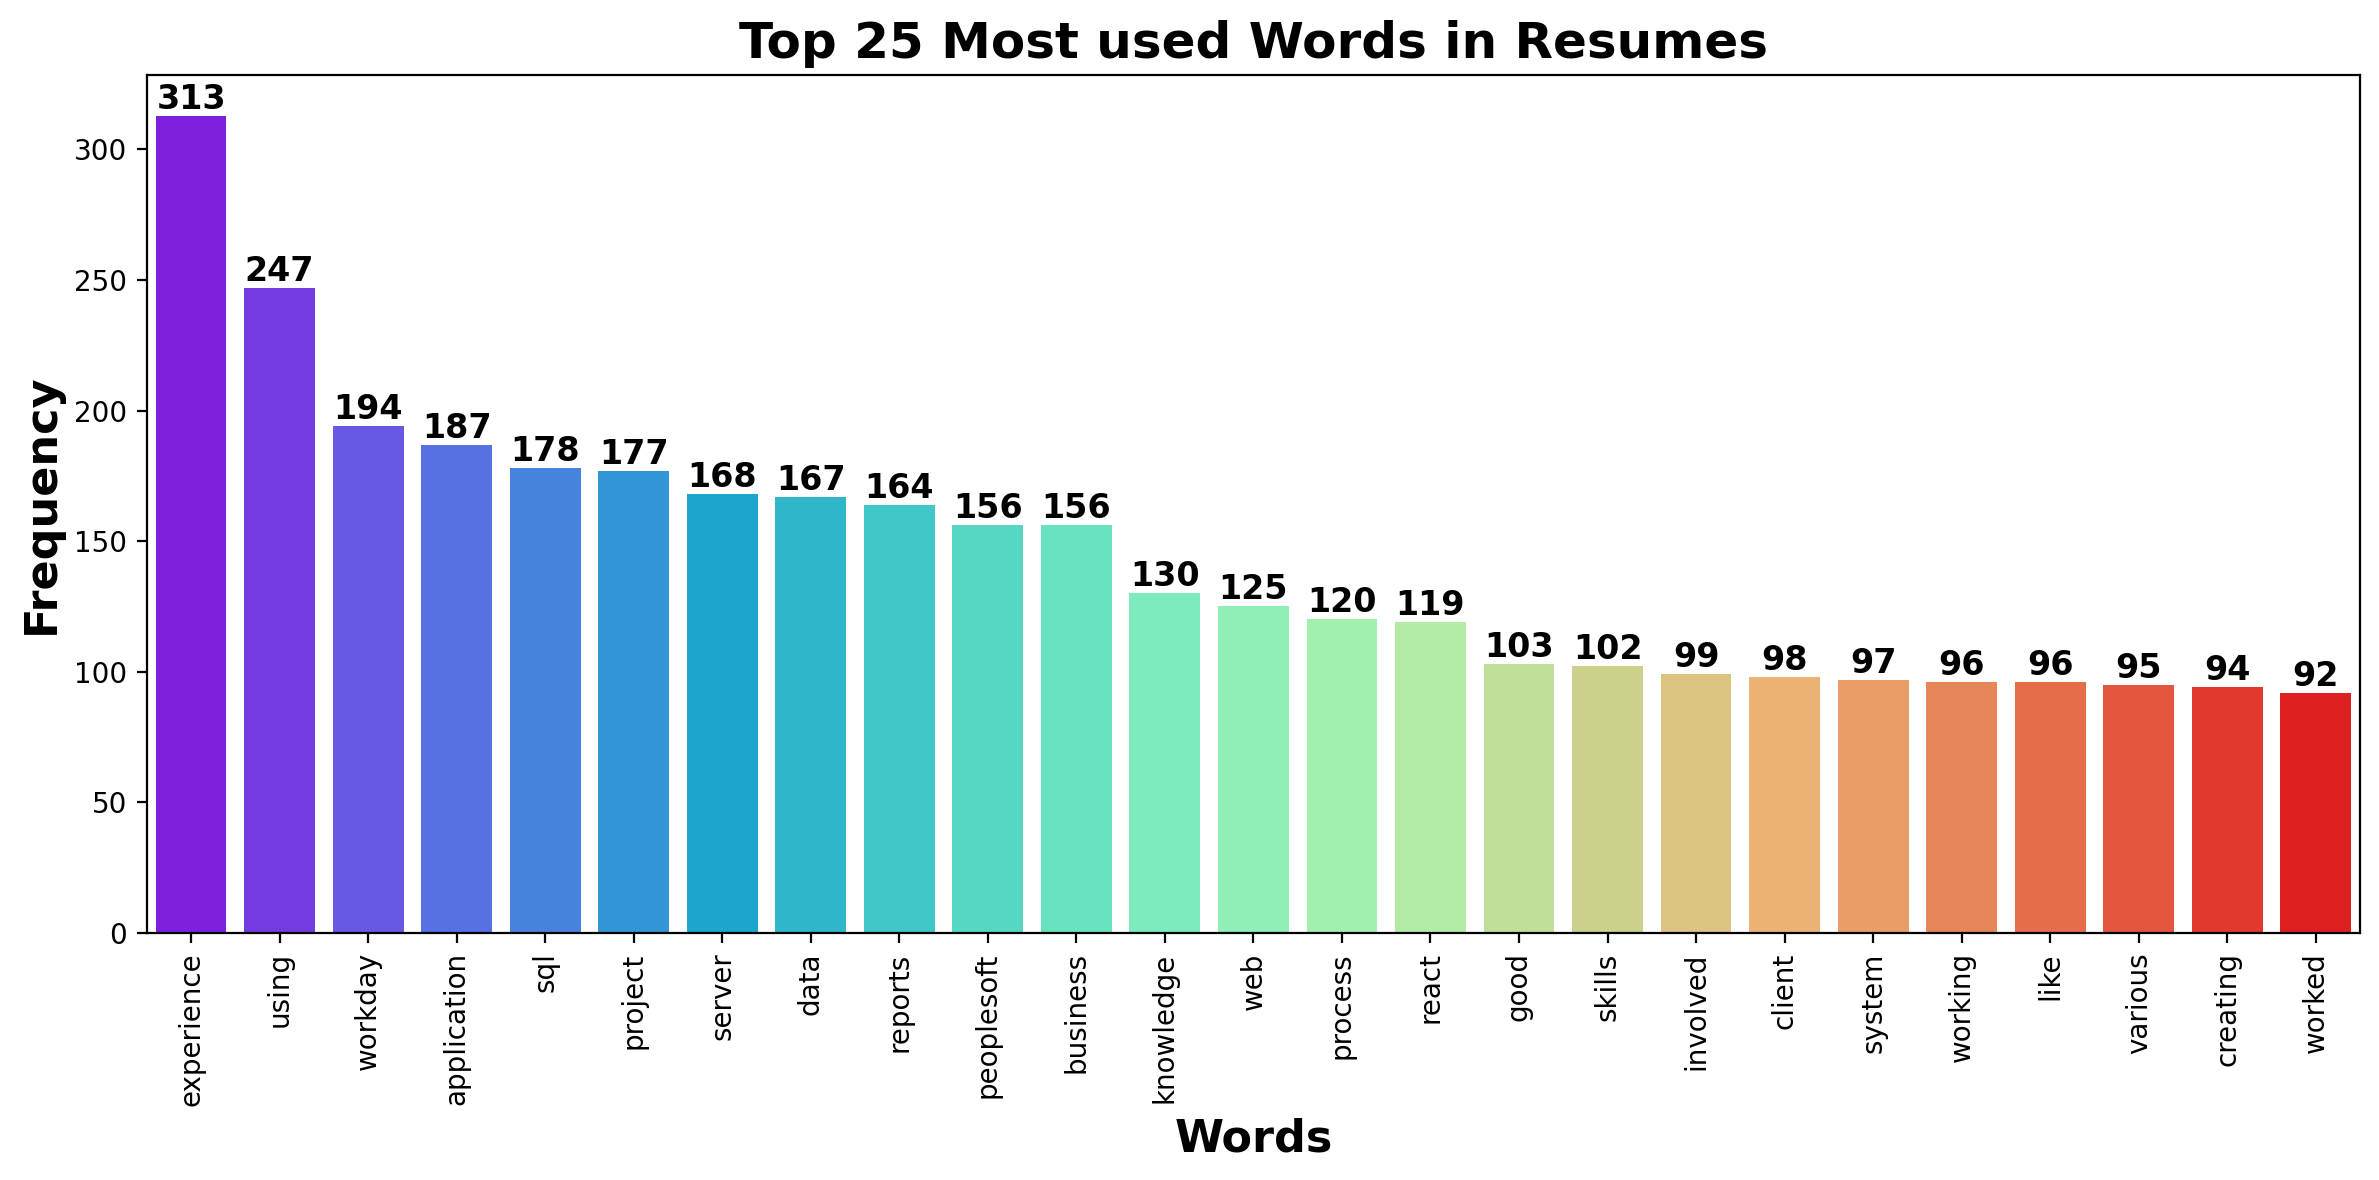

In [44]:
fig, axe = plt.subplots(1,1, figsize=(12,6), dpi=200)
colors = plt.cm.rainbow(np.linspace(0, 1, 25))
ax = sns.barplot(x=df_ngram['Unigram_Bigram'].head(25), y=df_ngram.Frequency.head(25), data=resume_data, ax = axe,
            label='Total Pofile Category : {}'.format(len(resume_data.folder.unique())),palette=colors )

axe.set_xlabel('Words', size=16,fontweight= 'bold')
axe.set_ylabel('Frequency', size=16, fontweight= 'bold')
plt.xticks(rotation = 90)
# plt.legend(loc='best', fontsize= 'x-large')
plt.title('Top 25 Most used Words in Resumes', fontsize= 18, fontweight= 'bold')
colors = plt.cm.rainbow(np.linspace(0, 1, len(x)))

for i in ax.containers:
    ax.bar_label(i,color = 'black', fontweight = 'bold', fontsize= 12)
fig.tight_layout()
plt.show()


### 5.4 Using the Word Clowds

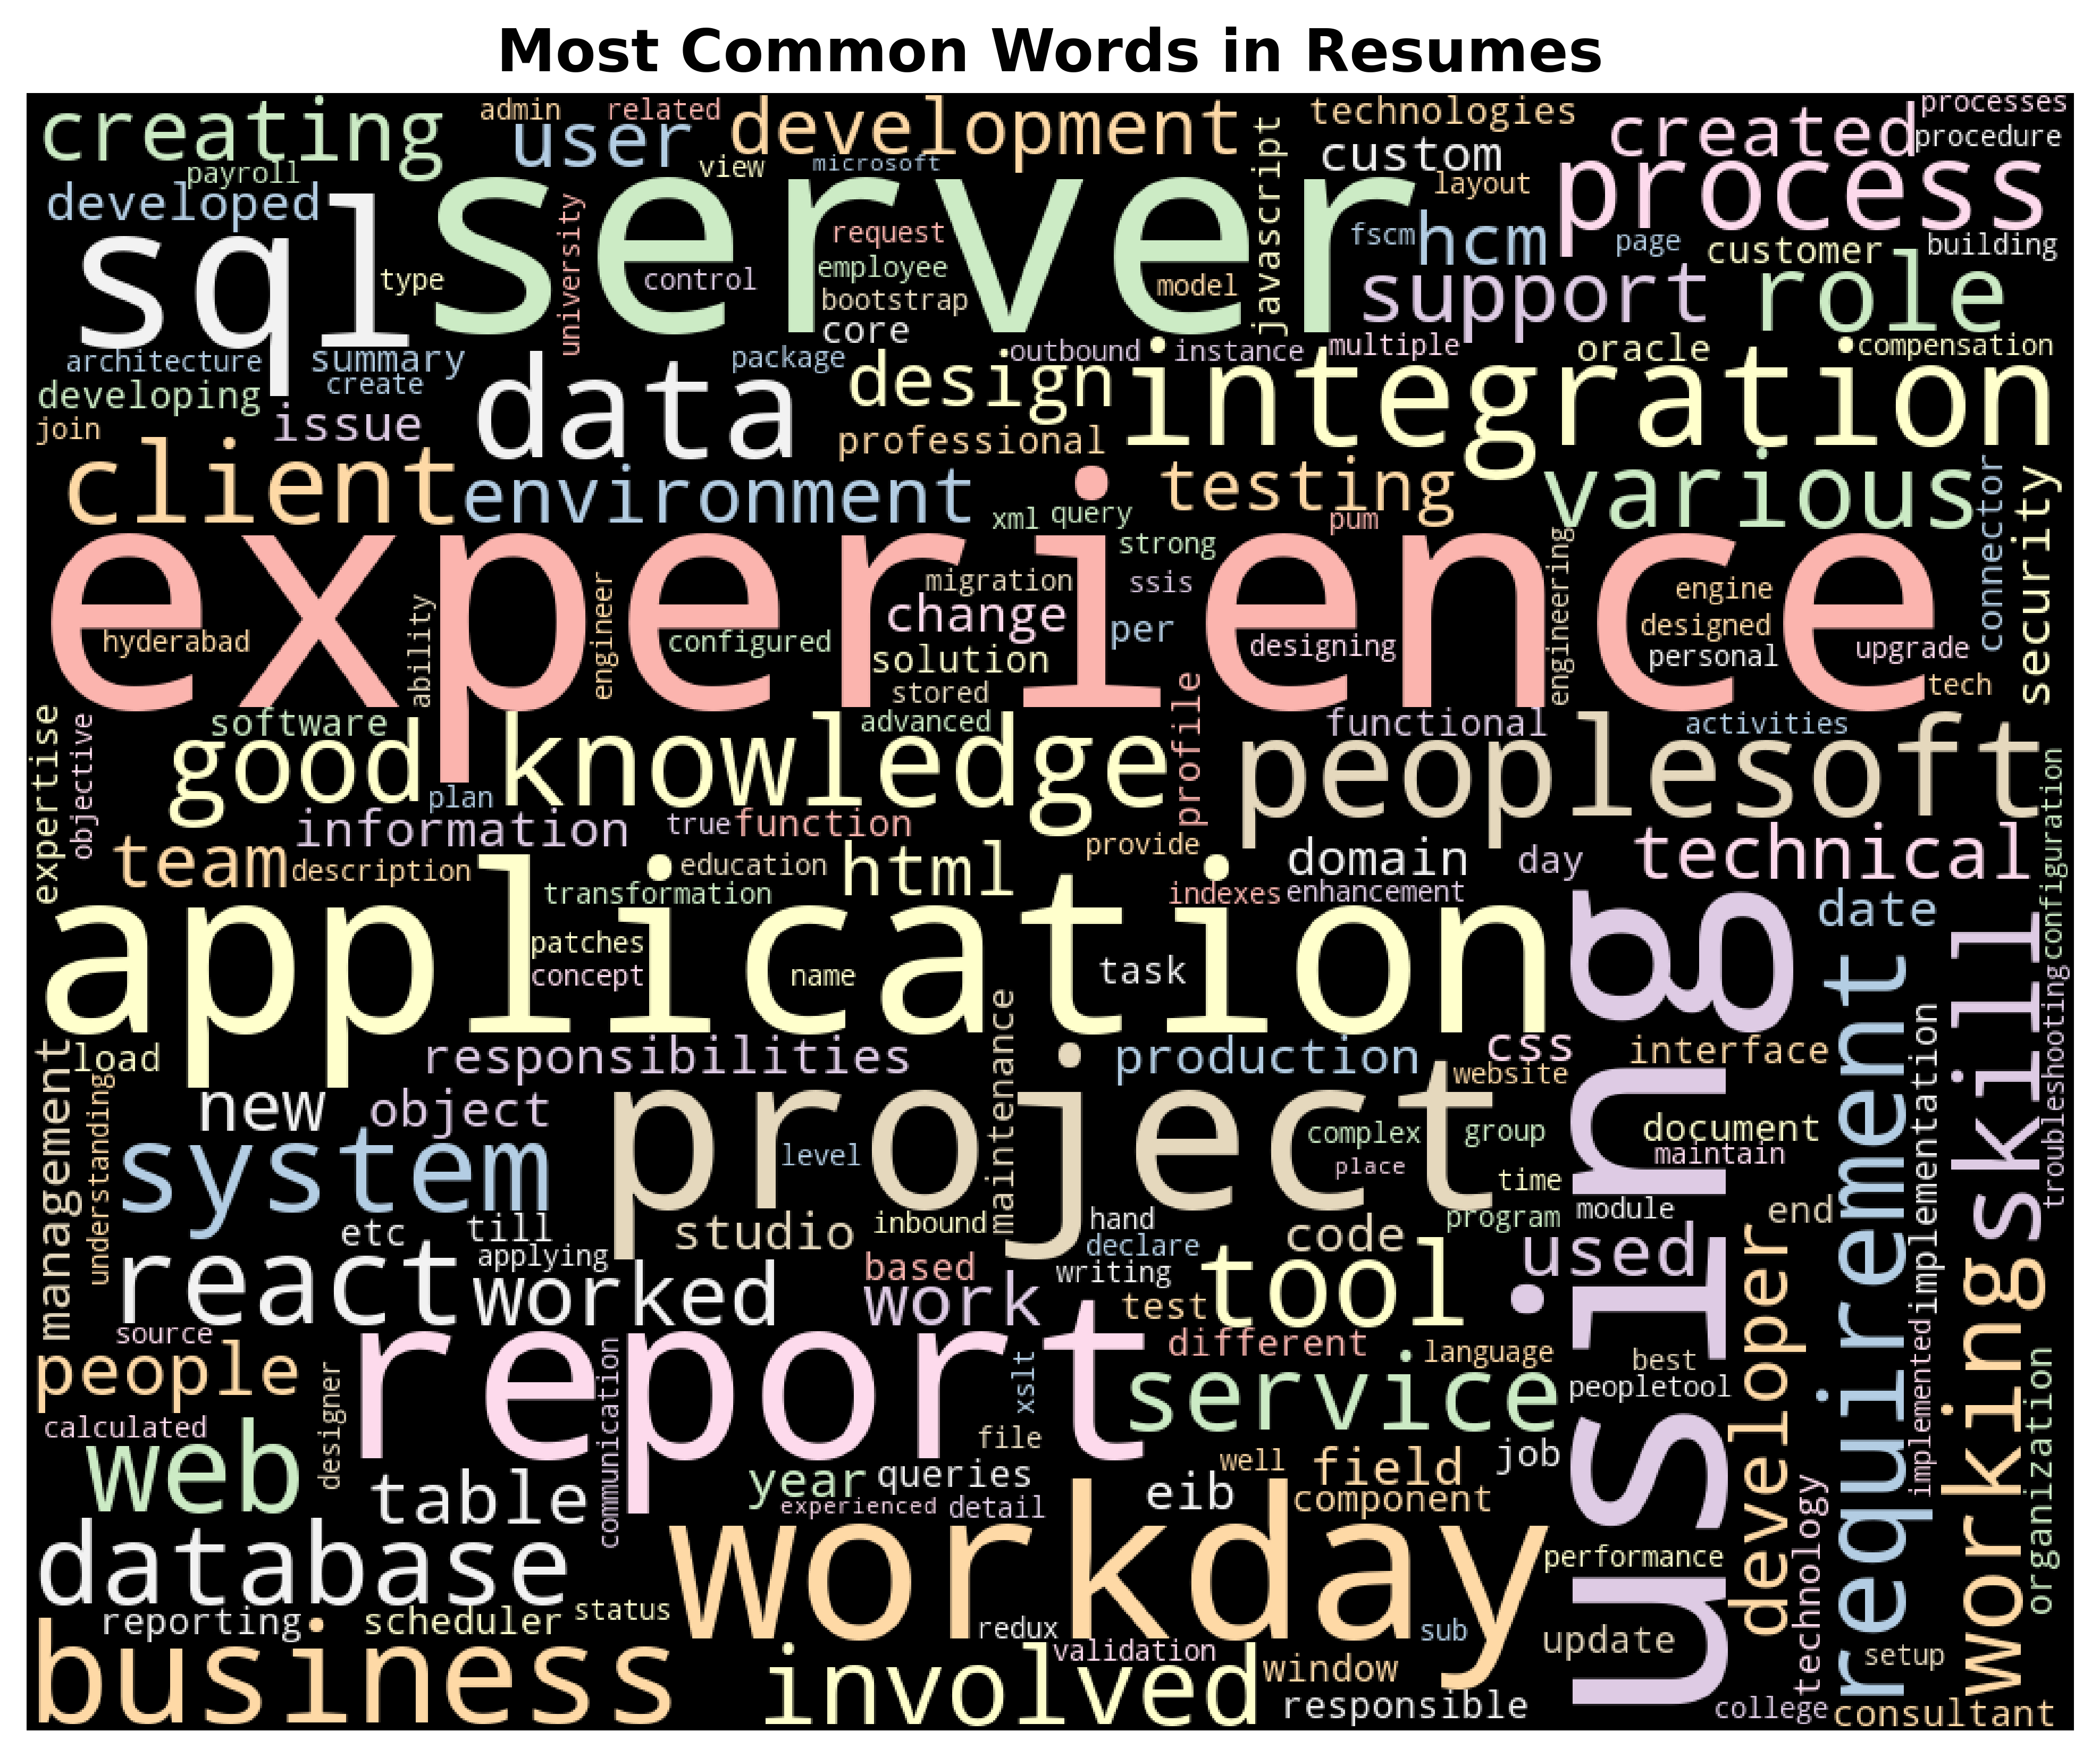

In [45]:
text = " ".join(cat for cat in resume_data.Resume_Details) 

word_cloud = WordCloud(width=1000, height=800, random_state=10, background_color="black", 
                       colormap="Pastel1", collocations=False, stopwords=STOPWORDS).generate(text)

plt.figure(figsize=(10,8), dpi=500) 
plt.title('Most Common Words in Resumes', fontsize= 16, fontweight= 'bold')
plt.imshow(word_cloud)
plt.axis("off")

# word_cloud.to_file('IMG/Word_Clowds.png')
plt.show()

## 6.Preprocessing and Encoding

In [46]:
encoder=LabelEncoder()
resume_data['Category']=encoder.fit_transform(resume_data['folder'])
resume_data.head()

,path,folder,ext,text,Word_Count,Char_Count,Stopwords,Numerics,Resume_Details,Category
0,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Anubhav Kumar Singh\t\t\n\n To work in a gl...,978,7256,187,3,anubhav kumar singh work globally competitive ...,0
1,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,Murali\n\nExperience Summary \n\nI have 6 year...,494,3981,111,1,murali experience summary years experience wor...,0
2,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,\n\n\n\n\n\n\n\n\n\n\n\n\n\nPROFILE SUMMARY\n\...,451,3646,86,15,profile summary overall years experience peopl...,0
3,Resumes_Docx/Peoplesoft Resume/Peoplesoft Admi...,Peoplesoft Resume,docx,PeopleSoft Admin\nVARKALA VIKAS\n\nCareer Obj...,881,7265,224,3,peoplesoft admin varkala vikas career objectiv...,0
4,Resumes_Docx/Peoplesoft Resume/PeopleSoft DBA_...,Peoplesoft Resume,docx,PeopleSoft Administration\n \nVivekanand Sayan...,2508,15339,519,16,peoplesoft administration vivekanand sayana ca...,0


In [47]:
resume_data.Category.unique()

array([0, 1, 2, 3])

In [74]:
x_train, x_test, y_train, y_test = train_test_split(resume_data['Resume_Details'], resume_data['Category'], test_size=0.2, random_state=42, stratify=resume_data['Category'])
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((42,), (11,), (42,), (11,))

### 7. TF-IDF Vectorization

In [86]:
tfidf_vector = TfidfVectorizer(sublinear_tf=True,stop_words='english')

In [87]:
tfidf_train_vectors  = tfidf_vector.fit_transform(x_train)
tfidf_valid_vectors = tfidf_vector.transform(x_test)

In [88]:
tfidf_train_vectors.shape, tfidf_valid_vectors.shape


((42, 2588), (11, 2588))

In [89]:
tfidf_vector.get_feature_names_out()

array(['ability', 'able', 'absence', ..., 'yield', 'yii', 'yogi'],
      shape=(2588,), dtype=object)

## 8. Classification Models

### 8.0 Training and Evaluate Function

In [186]:
def train_and_evaluate(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)

    train_acc = round(model.score(X_train, y_train), 2)
    test_acc = round(model.score(X_test, y_test), 2)

    precision = round(precision_score(y_test, y_pred, average='macro'), 2)
    recall = round(recall_score(y_test, y_pred, average='macro'), 2)
    f1 = round(f1_score(y_test, y_pred, average='macro'), 2)
    accuracy = round(accuracy_score(y_test, y_pred), 2)

    cm = confusion_matrix(y_test, y_pred)

    print(f"Accuracy (Train): {train_acc}")
    print(f"Accuracy (Test) : {test_acc}")
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    return {
        "train_accuracy": train_acc,
        "test_accuracy": test_acc,
        "precision": precision,
        "recall": recall,
        "f1_score": f1,
        "accuracy": accuracy,
        "confusion_matrix": cm
    }

In [187]:
results = []

### 8.1 Logistic Regresssion¶

In [188]:
model_lgr = LogisticRegression()
model_lgr_evaluate = train_and_evaluate(model_lgr,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["Logistic Regression"]+list(model_lgr_evaluate.values()))
model_lgr_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 0.82

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.71      1.00      0.83         5
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2

    accuracy                           0.82        11
   macro avg       0.93      0.75      0.79        11
weighted avg       0.87      0.82      0.80        11



{'train_accuracy': 1.0,
 'test_accuracy': 0.82,
 'precision': 0.93,
 'recall': 0.75,
 'f1_score': 0.79,
 'accuracy': 0.82,
 'confusion_matrix': array([[1, 1, 0, 0],
        [0, 5, 0, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 2]])}

### 8.2 KNN Classifier

In [189]:
model_knn = KNeighborsClassifier(n_neighbors=41)
model_knn_evaluate = train_and_evaluate(model_knn,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["KNN Classifier"]+list(model_knn_evaluate.values()))
model_knn_evaluate

Accuracy (Train): 0.38
Accuracy (Test) : 0.45

Classification Report:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00         2
           1       0.45      1.00      0.62         5
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2

    accuracy                           0.45        11
   macro avg       0.11      0.25      0.16        11
weighted avg       0.21      0.45      0.28        11



{'train_accuracy': 0.38,
 'test_accuracy': 0.45,
 'precision': 0.11,
 'recall': 0.25,
 'f1_score': 0.16,
 'accuracy': 0.45,
 'confusion_matrix': array([[0, 2, 0, 0],
        [0, 5, 0, 0],
        [0, 2, 0, 0],
        [0, 2, 0, 0]])}

### 8.3 Support Vectore Machine (SVM) Classifier

In [190]:
model_svm = SVC()
model_svm_evaluate = train_and_evaluate(model_svm,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["SVM Classifier"]+list(model_svm_evaluate.values()))
model_svm_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 0.82

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       0.71      1.00      0.83         5
           2       1.00      0.50      0.67         2
           3       1.00      1.00      1.00         2

    accuracy                           0.82        11
   macro avg       0.93      0.75      0.79        11
weighted avg       0.87      0.82      0.80        11



{'train_accuracy': 1.0,
 'test_accuracy': 0.82,
 'precision': 0.93,
 'recall': 0.75,
 'f1_score': 0.79,
 'accuracy': 0.82,
 'confusion_matrix': array([[1, 1, 0, 0],
        [0, 5, 0, 0],
        [0, 1, 1, 0],
        [0, 0, 0, 2]])}

### 8.4 Bagging Classifier


In [191]:
model_bagg = BaggingClassifier(KNeighborsClassifier(), max_samples=0.5, max_features=0.5)
model_bagg_evaluate = train_and_evaluate(model_bagg,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["Bagging Classifier"]+list(model_bagg_evaluate.values()))
model_bagg_evaluate

Accuracy (Train): 0.9
Accuracy (Test) : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



{'train_accuracy': 0.9,
 'test_accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'accuracy': 1.0,
 'confusion_matrix': array([[2, 0, 0, 0],
        [0, 5, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])}

### 8.5 Naive Bayes Classifier


In [192]:
model_NB =MultinomialNB(alpha=1, fit_prior=False, class_prior=None)
model_NB_evaluate = train_and_evaluate(model_NB,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["Naive Bayes Classifier"]+list(model_NB_evaluate.values()))
model_NB_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



{'train_accuracy': 1.0,
 'test_accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'accuracy': 1.0,
 'confusion_matrix': array([[2, 0, 0, 0],
        [0, 5, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])}

### 8.6 Random Forest Classifier

In [193]:
model_RF = RandomForestClassifier(n_estimators=200)
model_RF_evaluate = train_and_evaluate(model_RF,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["Random Forest Classifier"]+list(model_RF_evaluate.values()))
model_RF_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



{'train_accuracy': 1.0,
 'test_accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'accuracy': 1.0,
 'confusion_matrix': array([[2, 0, 0, 0],
        [0, 5, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])}

### 8.7 Decision Tree Classifier

In [194]:
model_DT = DecisionTreeClassifier(criterion='gini')
model_DT_evaluate = train_and_evaluate(model_DT,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["Decision Tree Classifier"]+list(model_DT_evaluate.values()))
model_DT_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 0.91

Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.50      0.67         2
           1       1.00      1.00      1.00         5
           2       0.67      1.00      0.80         2
           3       1.00      1.00      1.00         2

    accuracy                           0.91        11
   macro avg       0.92      0.88      0.87        11
weighted avg       0.94      0.91      0.90        11



{'train_accuracy': 1.0,
 'test_accuracy': 0.91,
 'precision': 0.92,
 'recall': 0.88,
 'f1_score': 0.87,
 'accuracy': 0.91,
 'confusion_matrix': array([[1, 0, 1, 0],
        [0, 5, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])}

### 8.8 XGBoost Classifier

In [195]:
model_xgb = XGBClassifier(objective='multi:softmax',num_class=len(set(y_train)),eval_metric='mlogloss')
model_xgb_evaluate = train_and_evaluate(model_xgb,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["XGBoost Classifier"]+list(model_xgb_evaluate.values()))
model_xgb_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



{'train_accuracy': 1.0,
 'test_accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'accuracy': 1.0,
 'confusion_matrix': array([[2, 0, 0, 0],
        [0, 5, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])}

### 8.9 LightGBM Classifier

In [196]:
model_lgb = LGBMClassifier(objective='multiclass',num_class=len(set(y_train)),learning_rate=0.1,n_estimators=300,verbose=-1)
model_lgb_evaluate = train_and_evaluate(model_lgb,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["LightGBM Classifier"]+list(model_lgb_evaluate.values()))
model_lgb_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 0.73

Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       1.00      0.80      0.89         5
           2       0.33      0.50      0.40         2
           3       1.00      0.50      0.67         2

    accuracy                           0.73        11
   macro avg       0.75      0.70      0.69        11
weighted avg       0.82      0.73      0.74        11



{'train_accuracy': 1.0,
 'test_accuracy': 0.73,
 'precision': 0.75,
 'recall': 0.7,
 'f1_score': 0.69,
 'accuracy': 0.73,
 'confusion_matrix': array([[2, 0, 0, 0],
        [0, 4, 1, 0],
        [1, 0, 1, 0],
        [0, 0, 1, 1]])}

### 8.10 Gradient Boosting Classifier

In [197]:
model_GradientBoost = GradientBoostingClassifier(n_estimators=100,learning_rate=1.0,max_depth=1, random_state=0)
model_GradientBoost_evaluate = train_and_evaluate(model_GradientBoost,tfidf_train_vectors,y_train,tfidf_valid_vectors,y_test)
results.append(["Gradient Boosting Classifier"]+list(model_GradientBoost_evaluate.values()))
model_GradientBoost_evaluate

Accuracy (Train): 1.0
Accuracy (Test) : 1.0

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00         2
           1       1.00      1.00      1.00         5
           2       1.00      1.00      1.00         2
           3       1.00      1.00      1.00         2

    accuracy                           1.00        11
   macro avg       1.00      1.00      1.00        11
weighted avg       1.00      1.00      1.00        11



{'train_accuracy': 1.0,
 'test_accuracy': 1.0,
 'precision': 1.0,
 'recall': 1.0,
 'f1_score': 1.0,
 'accuracy': 1.0,
 'confusion_matrix': array([[2, 0, 0, 0],
        [0, 5, 0, 0],
        [0, 0, 2, 0],
        [0, 0, 0, 2]])}

In [198]:
clean_results = [row[:-1] for row in results]
clean_results
columns = ["Model", "Train Accuracy", "Test Accuracy", 
           "Precision", "Recall", "F1 Score", "Accuracy"]

df = pd.DataFrame(clean_results, columns=columns)
df

,Model,Train Accuracy,Test Accuracy,Precision,Recall,F1 Score,Accuracy
0,Logistic Regression,1.00,0.82,0.93,0.75,0.79,0.82
1,KNN Classifier,0.38,0.45,0.11,0.25,0.16,0.45
2,SVM Classifier,1.00,0.82,0.93,0.75,0.79,0.82
3,Bagging Classifier,0.90,1.00,1.00,1.00,1.00,1.00
4,Naive Bayes Classifier,1.00,1.00,1.00,1.00,1.00,1.00
5,Random Forest Classifier,1.00,1.00,1.00,1.00,1.00,1.00
6,Decision Tree Classifier,1.00,0.91,0.92,0.88,0.87,0.91
7,XGBoost Classifier,1.00,1.00,1.00,1.00,1.00,1.00
8,LightGBM Classifier,1.00,0.73,0.75,0.70,0.69,0.73
9,Gradient Boosting Classifier,1.00,1.00,1.00,1.00,1.00,1.00
